 <h1><center> <font color='green'>CNN-TL_MobileNetv2
 </font></center></h1> 

 <h1><center> <font color='blue'>Librerías</font></center></h1>

In [1]:
"""Importar librerias para realizar CNN"""
import os
"""Cargar las imagenes"""
import cv2
from PIL import Image
"""Tensoflow para las redes neuronales"""
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
"""Librería para calculo numerico"""
import numpy as np
"""Libreria para graficas"""
import matplotlib.pyplot as plt
"""Importa para dividir el conjunto de datos en entrenamiento y prueba"""
from sklearn.model_selection import train_test_split
"""Librería que que ofrece metricas"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
"""Importa datos de señales de registro de archivos de ejecuciones
de simulación disponibles para la aplicación en tiempo real seleccionadas"""
import time
import math
import logging

2023-07-18 14:12:26.110696: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 14:12:26.154942: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 14:12:26.155595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 14:12:26.916523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h1><center> <font color='orange'>Carga y exploración de datos</font></center></h1> 

In [166]:
"""Definición del tamaño, array de las imagenes"""
IMG_SHAPE  = 224
batch_size = 32
random_seed = 9

In [3]:
#Carga de datos
fpath = './DATASET CACAO'
categories = os.listdir(fpath)
categories.sort()

print("List of categories = ", categories)
print("\n\nNo. of categories = ", len(categories))

List of categories =  ['FASE 0', 'FASE 1', 'FASE 2', 'FASE 3', 'FASE 4', 'FASE 5', 'FASE 6']


No. of categories =  7


In [4]:
"""Funcion para cargar las imagenes por categorias"""
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')

            img_lst.append(np.array(img_array))

            labels.append(index)
    return img_lst, labels
"""Cargar las imagenes desde las categorias"""
images, labels = load_images_and_labels(categories)
"""Mostrar la cantidad de imagenes cargadas"""
print("Nº de imágenes cargadas = ",len(images),"\nNo. de etiquetas cargadas = ",len(labels))
print(type(images),type(labels))

Nº de imágenes cargadas =  1400 
No. de etiquetas cargadas =  1400
<class 'list'> <class 'list'>


In [5]:
"""Variables para ver el array de las imagenes y los label"""
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1400, 224, 224, 3) 
Labels shape =  (1400,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


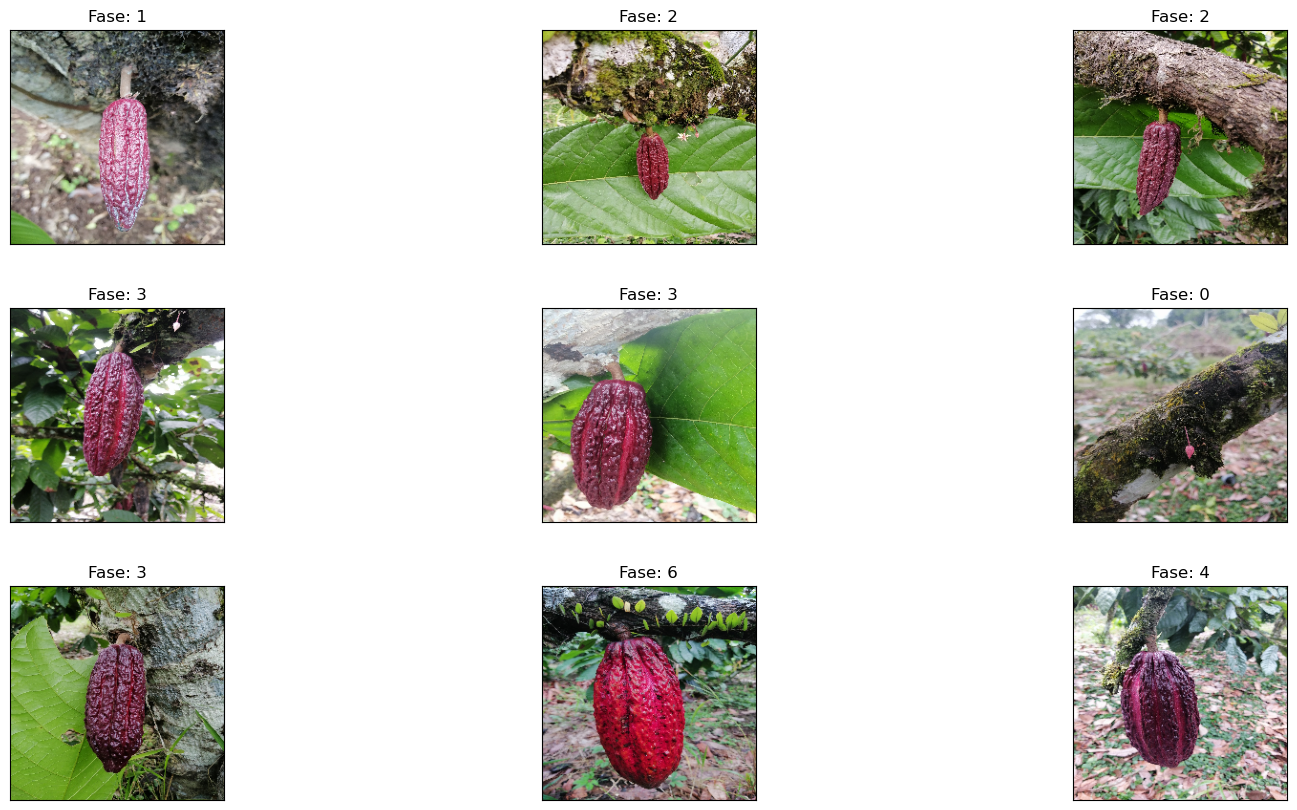

In [6]:
"""Función para visualizar imagenes aleatorias """
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
 
        plt.title('Fase: {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
"""Mostrar imagenes con sus labels"""
display_rand_images(images, labels)

<h1><center> <font color='brow'>Definición del conjunto de datos para pruebas y entrenamiento</font></center></h1>

In [7]:
"""Primero se reorganizan los datos"""

"""Obtener números igualmente espaciados en un rango dado"""
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

"""Mezclar todos los valores igualmente espaciados en la lista 'n'"""
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1397 1398 1399]

'n' values after shuffling =  [ 196 1358  271 ...  638  348  382]


### Shuffling

In [8]:
"""El segundo paso es la mezcla de datos"""

"""imágenes aleatorias y datos de etiquetas correspondientes en ambas listas"""
images = images[n]
labels = labels[n]

print("Forma de las imágenes después de la mezcla = ",images.shape,"\nForma de las etiquetas después de mezclar= ",labels.shape)

Forma de las imágenes después de la mezcla =  (1400, 224, 224, 3) 
Forma de las etiquetas después de mezclar=  (1400,)


### Normalización

In [9]:
"""Normalizacion de los datos, segun su tipo: float, int"""
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Forma de las imágenes después de la normalización = ",images.shape)

Forma de las imágenes después de la normalización =  (1400, 224, 224, 3)


# Training and Testing

In [10]:
'''Se divide el conjunto de datos en 80% para entrenamiento y 20% para prueba'''
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

"""Mostrar los array en cada parte del entrenamiento y la prueba"""

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (1062, 224, 224, 3)
y_train shape =  (1062,)

x_test shape =  (280, 224, 224, 3)
y_test shape =  (280,)

x_val shape =  (58, 224, 224, 3)
y_val shape =  (58,)


In [11]:
"""Estructura One-hot-encode"""
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)
y_val = to_categorical(y_val, 7)


 <h1><center> <font color='purple'>Implementación del modelo CNN con MobileNetV2</font></center></h1> 

In [230]:
"""Función para el pre-entrenamiento del modelo, con MobileNetV2"""
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False, weights="imagenet")


In [231]:
"""Pre-entrenar el modelo por capas"""
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_15
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expan

In [232]:
"""Configuracion de la ultima capa y la capa de salida"""
last_layer = pre_trained_model.get_layer('out_relu')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(pre_trained_model.input, x)

## GridSearchCV

In [233]:
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    """Configuracion de la ultima capa y la capa de salida"""
    last_layer = pre_trained_model.get_layer('out_relu')
    last_output = last_layer.output
    x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(7, activation='softmax')(x)
    model = tf.keras.Model(pre_trained_model.input, x)
    """Configuracion para compilar el modelo, tambien se optimiza"""
    model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])
    return model


## GridSheach Result

In [234]:
#model = KerasClassifier(model=create_model, verbose=1)
#print(model.get_params().keys())
# grid search epochs, batch size and optimizer
#optimizers = ['rmsprop', 'adam','SGD']
#init = ['glorot_uniform', 'normal', 'uniform']
#epochs = [10,20, 30,40,50]
#batches = [10, 20, 30,40]
#param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, model__init=init)
#grid = GridSearchCV(estimator=model, param_grid=param_grid)
#grid_result = grid.fit(x_train, y_train)
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Entrenamiento del Modelo

In [235]:
"""Configuracion para compilar el modelo, tambien se optimiza"""
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [236]:
"""Resumen del Modelo"""
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_15[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']     

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [237]:
"""Estructuras los espoch y su tamaño"""
steps_per_epoch = (x_train.shape[0]//batch_size)
"""Validar los pesos"""
validation_steps = (x_val.shape[0] // batch_size)
es = EarlyStopping(monitor='loss', mode='min', verbose=1,start_from_epoch =5)

In [238]:
"""Visualizar el array de los datos de entrenamiento"""
x_train.shape,y_train.shape

((1062, 224, 224, 3), (1062, 7))

## Evaluación del modelo

In [239]:
"""Función de inicio del tiempo"""
start_time = time.time()

"""Estructura de los historys para el entrenamiento del modelo"""
history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

Epoch 1/50
33/33 [==============================] - 8s 174ms/step - loss: 4.1912 - acc: 0.4205 - val_loss: 0.6380 - val_acc: 0.7500
Epoch 2/50
33/33 [==============================] - 5s 157ms/step - loss: 0.9295 - acc: 0.6583 - val_loss: 0.5957 - val_acc: 0.7500
Epoch 3/50
33/33 [==============================] - 5s 156ms/step - loss: 0.7682 - acc: 0.6961 - val_loss: 0.6222 - val_acc: 0.7500
Epoch 4/50
33/33 [==============================] - 5s 146ms/step - loss: 0.6643 - acc: 0.7515 - val_loss: 0.5882 - val_acc: 0.7812
Epoch 5/50
33/33 [==============================] - 5s 143ms/step - loss: 0.5946 - acc: 0.7777 - val_loss: 0.5398 - val_acc: 0.7812
Epoch 6/50
33/33 [==============================] - 5s 148ms/step - loss: 0.5690 - acc: 0.7786 - val_loss: 0.4142 - val_acc: 0.9062
Epoch 7/50
33/33 [==============================] - 5s 143ms/step - loss: 0.4626 - acc: 0.8214 - val_loss: 0.4222 - val_acc: 0.9062
Epoch 8/50
33/33 [==============================] - 5s 140ms/step - loss: 0.

In [250]:
"""Crear un archivo de tipo json"""
model_json = model.to_json()
with open("MobileNetv2_Vocales_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("MobileNetv2_Vocales_Classifier.h5")
"""Guardar en el disco duro"""
print("Saved model to disk")
model.save_weights("MobileNetv2_Vocales.h5")

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


# Evaluación del modelo

In [240]:
"""Función de inicio del tiempo"""
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Tiempo de ejecución de la evaluación: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

9/9 [==============================] - 1s 154ms/step - loss: 0.2654 - acc: 0.9143
test_loss: 26.54
test_accuracy: 91.43


### Métricas de Evaluación

In [241]:
"""Función para las pruebas del modelo"""
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
"""predecir clases nítidas para el conjunto de prueba"""
model_classes = np.argmax(model_probs,axis=1)
"""reducir a matriz 1d"""
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
"""Accuracy: (tp + tn) / (p + n)"""
accuracy = accuracy_score(y_test_reduced, model_classes)*100
"""Precision tp / (tp + fp)"""
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
"""Recall: tp / (tp + fn)"""
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
"""F1: 2 tp / (2 tp + fp + fn)"""
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 91.43
F1 score: 91.45
Precision: 91.59
Recall: 91.43


## Gráfica de los History

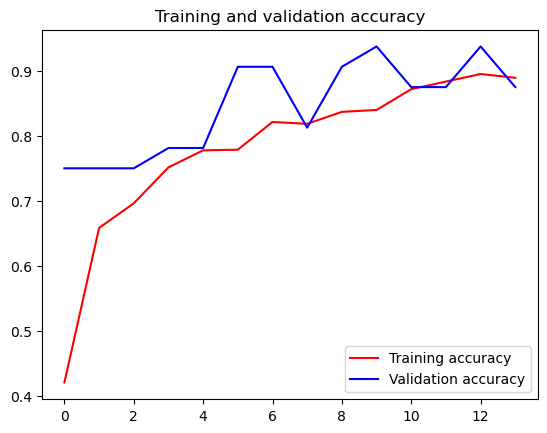

In [242]:
"""Funciones para graficar los history de validacion y el accuracy"""
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TLMobileNetv2.png")
plt.show()

In [243]:
"""Predicción del Modelo"""
y_pred = model.predict(x_test)

9/9 [==============================] - 1s 144ms/step


In [244]:
"""Mostrar el array del y_pred"""
y_pred.round()

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [245]:
"""Visualizar las métricas del modelo"""
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred.round(), y_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.89      0.98      0.93        41
           2       0.90      0.95      0.92        37
           3       0.81      0.81      0.81        36
           4       0.84      0.91      0.88        47
           5       0.82      0.97      0.89        33
           6       0.98      1.00      0.99        41

   micro avg       0.89      0.94      0.91       264
   macro avg       0.89      0.94      0.91       264
weighted avg       0.89      0.94      0.91       264
 samples avg       0.89      0.89      0.89       264



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [246]:
"""Visualización del Accuracy"""
accuracy = model.evaluate(x_test,y_test,batch_size=32)
print("Accuracy: ",accuracy[1]*100)

9/9 [==============================] - 1s 151ms/step - loss: 0.2654 - acc: 0.9143
Accuracy:  91.42857193946838


In [247]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1)

In [248]:
"""Reporte de clasificación de las métricas"""
report = classification_report(Y_true, Y_pred_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

      FASE 0       0.93      1.00      0.97        28
      FASE 1       0.98      0.93      0.95        45
      FASE 2       0.95      0.92      0.94        39
      FASE 3       0.78      0.81      0.79        36
      FASE 4       0.85      0.90      0.88        51
      FASE 5       0.92      0.85      0.88        39
      FASE 6       1.00      1.00      1.00        42

    accuracy                           0.91       280
   macro avg       0.92      0.92      0.92       280
weighted avg       0.92      0.91      0.91       280



# Matriz de confusión

In [249]:
"""Estructurar la matriz de confusion"""
confusion = confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[28  0  0  0  0  0  0]
 [ 1 42  0  2  0  0  0]
 [ 0  1 36  2  0  0  0]
 [ 1  0  2 29  3  1  0]
 [ 0  0  0  3 46  2  0]
 [ 0  0  0  1  5 33  0]
 [ 0  0  0  0  0  0 42]]


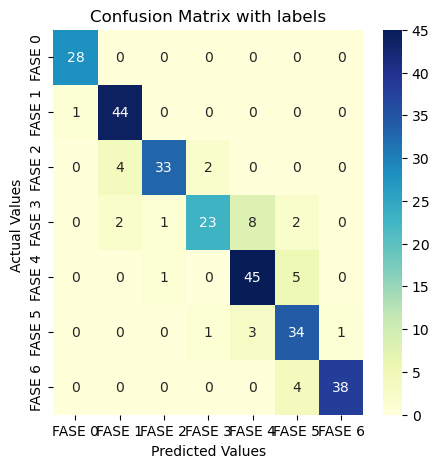

In [229]:
"""Librería para graficar la matriz de confusion"""
import seaborn as sns
plt.figure(figsize=(5, 5))

ma = sns.heatmap(confusion, cmap="YlGnBu", annot=True)
ma.set_title('Confusion Matrix with labels')
ma.set_xlabel('Predicted Values')
ma.set_ylabel('Actual Values ')
ma.xaxis.set_ticklabels(categories)
ma.yaxis.set_ticklabels(categories)

plt.show()